In [4]:
# imbalance_handling_pima.ipynb

# ===============================================================
# 1. Setup
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")






In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(768, 9)


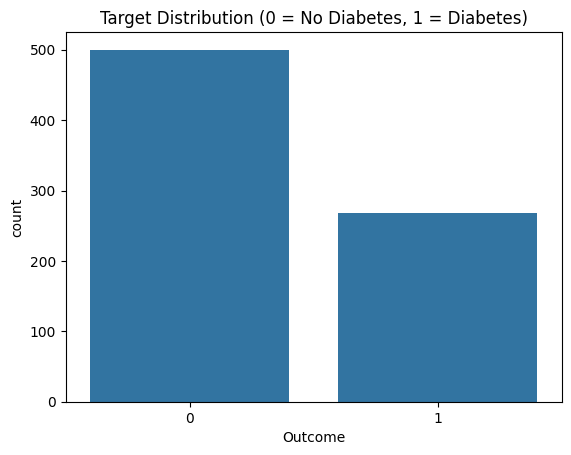

,proportion
Outcome,
0,0.651042
1,0.348958


In [6]:

# ===============================================================
# 2. Load Dataset
# ===============================================================
df=pd.read_csv('/content/drive/MyDrive/0.Latest_DS_Course/Ensemble/1.Bagging/Diabetes.csv')
print(df.shape)
df.head()

# Target distribution
sns.countplot(x="Outcome", data=df)
plt.title("Target Distribution (0 = No Diabetes, 1 = Diabetes)")
plt.show()

df["Outcome"].value_counts(normalize=True)




In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
# ===============================================================
# 3. Train-Test Split
# ===============================================================
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
# ===============================================================
# 4. Helper function
# ===============================================================
def evaluate_model(model, X_train, y_train, X_test, y_test, title="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    print(f"\n===== {title} =====")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    if y_prob is not None:
        print("ROC-AUC:", roc_auc_score(y_test, y_prob))



In [10]:
# ===============================================================
# 5. Base Model (No Resampling)
# ===============================================================
lr = LogisticRegression(max_iter=500)
evaluate_model(lr, X_train, y_train, X_test, y_test, "Baseline Logistic Regression")



===== Baseline Logistic Regression =====
[[130  20]
 [ 39  42]]
              precision    recall  f1-score   support

           0     0.7692    0.8667    0.8150       150
           1     0.6774    0.5185    0.5874        81

    accuracy                         0.7446       231
   macro avg     0.7233    0.6926    0.7012       231
weighted avg     0.7370    0.7446    0.7352       231

ROC-AUC: 0.8379423868312756


In [11]:
# ===============================================================
# 6. Undersampling
# ===============================================================
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

evaluate_model(lr, X_rus, y_rus, X_test, y_test, "Random Undersampling + Logistic Regression")



===== Random Undersampling + Logistic Regression =====
[[118  32]
 [ 21  60]]
              precision    recall  f1-score   support

           0     0.8489    0.7867    0.8166       150
           1     0.6522    0.7407    0.6936        81

    accuracy                         0.7706       231
   macro avg     0.7505    0.7637    0.7551       231
weighted avg     0.7799    0.7706    0.7735       231

ROC-AUC: 0.8372839506172839


In [12]:
# ===============================================================
# 7. Oversampling
# ===============================================================
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

evaluate_model(lr, X_ros, y_ros, X_test, y_test, "Random Oversampling + Logistic Regression")



===== Random Oversampling + Logistic Regression =====
[[121  29]
 [ 24  57]]
              precision    recall  f1-score   support

           0     0.8345    0.8067    0.8203       150
           1     0.6628    0.7037    0.6826        81

    accuracy                         0.7706       231
   macro avg     0.7486    0.7552    0.7515       231
weighted avg     0.7743    0.7706    0.7721       231

ROC-AUC: 0.8367901234567902


In [13]:
# ===============================================================
# 8. SMOTE
# ===============================================================
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)

evaluate_model(lr, X_sm, y_sm, X_test, y_test, "SMOTE + Logistic Regression")




===== SMOTE + Logistic Regression =====
[[120  30]
 [ 25  56]]
              precision    recall  f1-score   support

           0     0.8276    0.8000    0.8136       150
           1     0.6512    0.6914    0.6707        81

    accuracy                         0.7619       231
   macro avg     0.7394    0.7457    0.7421       231
weighted avg     0.7657    0.7619    0.7635       231

ROC-AUC: 0.8389300411522634


In [14]:
# ===============================================================
# 9. Class Weighting
# ===============================================================
lr_weighted = LogisticRegression(max_iter=500, class_weight="balanced")
evaluate_model(lr_weighted, X_train, y_train, X_test, y_test, "Class Weighting + Logistic Regression")




===== Class Weighting + Logistic Regression =====
[[119  31]
 [ 23  58]]
              precision    recall  f1-score   support

           0     0.8380    0.7933    0.8151       150
           1     0.6517    0.7160    0.6824        81

    accuracy                         0.7662       231
   macro avg     0.7449    0.7547    0.7487       231
weighted avg     0.7727    0.7662    0.7685       231

ROC-AUC: 0.8376954732510288


In [15]:
# ===============================================================
# 10. Balanced Random Forest
# ===============================================================
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(brf, X_train, y_train, X_test, y_test, "Balanced Random Forest")



===== Balanced Random Forest =====
[[119  31]
 [ 29  52]]
              precision    recall  f1-score   support

           0     0.8041    0.7933    0.7987       150
           1     0.6265    0.6420    0.6341        81

    accuracy                         0.7403       231
   macro avg     0.7153    0.7177    0.7164       231
weighted avg     0.7418    0.7403    0.7410       231

ROC-AUC: 0.8387654320987654


In [16]:
# ===============================================================
# 11. Easy Ensemble
# ===============================================================
eec = EasyEnsembleClassifier(n_estimators=50, random_state=42)
evaluate_model(eec, X_train, y_train, X_test, y_test, "Easy Ensemble")




===== Easy Ensemble =====
[[114  36]
 [ 24  57]]
              precision    recall  f1-score   support

           0     0.8261    0.7600    0.7917       150
           1     0.6129    0.7037    0.6552        81

    accuracy                         0.7403       231
   macro avg     0.7195    0.7319    0.7234       231
weighted avg     0.7513    0.7403    0.7438       231

ROC-AUC: 0.8385185185185186


In [17]:
# ===============================================================
# 12. Comparison
# ===============================================================
# You can log results into a dict or DataFrame to compare


In [18]:
# Fine-tuning Balanced Random Forest

In [19]:
param_grid_brf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10]
}

grid_brf = GridSearchCV(
    BalancedRandomForestClassifier(random_state=42),
    param_grid_brf,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

grid_brf.fit(X_train, y_train)
print("Best Params (BRF):", grid_brf.best_params_)

y_pred = grid_brf.best_estimator_.predict(X_test)
print("Tuned Balanced RF Report:")
print(classification_report(y_test, y_pred))


Best Params (BRF): {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Tuned Balanced RF Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       150
           1       0.63      0.70      0.67        81

    accuracy                           0.75       231
   macro avg       0.73      0.74      0.74       231
weighted avg       0.76      0.75      0.76       231



In [20]:
# 🔧 Fine-tuning Easy Ensemble

In [21]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_eec = {
    "n_estimators": [10, 20, 30],   # number of subsets to sample
    "estimator__n_estimators": [50, 100],  # RF trees inside each ensemble
    "estimator__max_depth": [5, 10, None]
}

# Correct usage: use estimator instead of base_estimator
grid_eec = GridSearchCV(
    EasyEnsembleClassifier(random_state=42, estimator=RandomForestClassifier()),
    param_grid_eec,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

grid_eec.fit(X_train, y_train)

print("Best params:", grid_eec.best_params_)
print("Best F1 score:", grid_eec.best_score_)


Best params: {'estimator__max_depth': 10, 'estimator__n_estimators': 100, 'n_estimators': 10}
Best F1 score: 0.6502531308286703
